# Imports

In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import os

import cv2

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

from tensorflow.python.keras import optimizers

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.preprocessing.image import load_img

# Global parameters

In [60]:
# Fixed for our Hot Dog & Pizza classes
NUM_CLASSES = 2

# Fixed for Hot Dog & Pizza color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 5
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

# The name of the .h5 file containing the pretrained weights for the ResNet50
WEIGHTS_FILE = 'resnet50_weights_notop.h5'

# Work directory to save the checkpoints
WORK_FOLDER = 'working'

# Checkpoint file name
CHECKPOINT_FILE = 'best.hdf5'

In [61]:
# Base folder path for the Hot Dog & Pizza classification images
BASE_FOLDER_PATH = os.path.join('datasets', 'hotdog_pizza')

# The path to the training images
TRAIN_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'train')

# The path to the validation images
VALIDATION_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'valid')

# The path to the test images
TEST_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'test')

# Checkpoint file path
CHECKPOINT_FILE_PATH = os.path.join(WORK_FOLDER, CHECKPOINT_FILE)

# Transfer Learning

In [4]:
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = WEIGHTS_FILE))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.


## Summary of the model

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


## Compile the model

In [8]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

# Prepare the Data Generator

In [9]:
image_size = IMAGE_RESIZE

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        TRAIN_FOLDER_PATH,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        VALIDATION_FOLDER_PATH,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 1500 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [10]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 15, 100, 3)

# Train the model

In [12]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)

cb_checkpointer = ModelCheckpoint(filepath = CHECKPOINT_FILE_PATH, monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [13]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper],
        verbose=1
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
15/15 [==============================] - 363s 24s/step - loss: 0.3332 - acc: 0.8573 - val_loss: 0.1309 - val_acc: 0.9433
Epoch 2/5
15/15 [==============================] - 352s 23s/step - loss: 0.0839 - acc: 0.9753 - val_loss: 0.0396 - val_acc: 0.9833
Epoch 3/5
15/15 [==============================] - 346s 23s/step - loss: 0.0531 - acc: 0.9847 - val_loss: 0.0477 - val_acc: 0.9767
Epoch 4/5
15/15 [==============================] - 313s 21s/step - loss: 0.0456 - acc: 0.9860 - val_loss: 0.0520 - val_acc: 0.9767
Epoch 5/5
15/15 [==============================] - 330s 22s/step - loss: 0.0318 - acc: 0.9907 - val_loss: 0.0438 - val_acc: 0.9767


In [14]:
model.load_weights(CHECKPOINT_FILE_PATH)

# Metrics

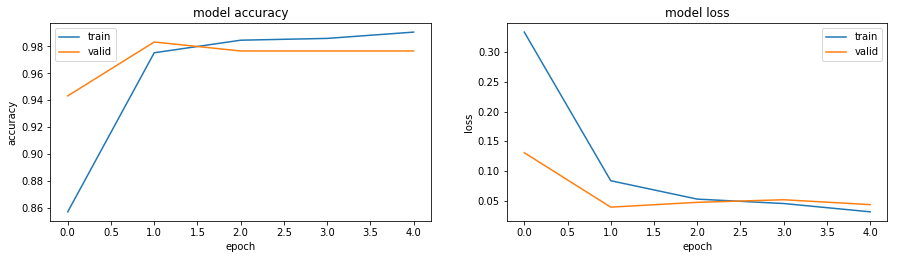

In [15]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

# Test the model

In [68]:
test_generator = data_generator.flow_from_directory(
    directory = TEST_FOLDER_PATH,
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 200 images belonging to 2 classes.


## Visualize predictions

In [69]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

200/200 [==============================] - 62s 309ms/step


In [70]:
test_generator.filenames[0]

'hot_dog\\101571.jpg'

In [71]:
read = lambda image_name: np.asarray(load_img(image_name, target_size=(224, 224)))

def plot_image(base_path, images, image_count, labels, image_width=18, image_height=12):
    fig=plt.figure(figsize=(image_width, image_height))
    
    columns = 10
    rows = image_count // columns

    for i in range(1, columns*rows + 1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(labels[i])
        img = read(os.path.join(base_path, images[i]))
        plt.imshow(img, interpolation='nearest')

In [158]:
labels = ["Pizza" if predicted_class_indices[i] else "Hot Dog" for i in range(len(predicted_class_indices))]

In [159]:
labels

['Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot 

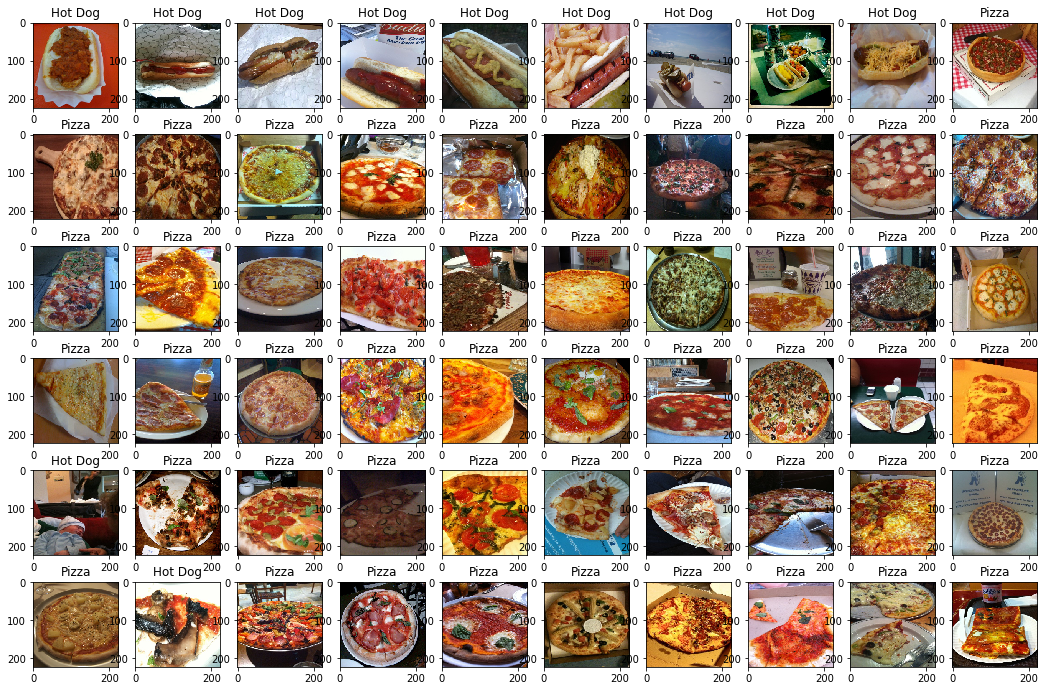

In [74]:
plot_image(TEST_FOLDER_PATH, test_generator.filenames[90:151], 60, labels[90:151])

In [227]:
test_image_pizza_path = os.path.join(TEST_FOLDER_PATH, 'pizza', '27963.jpg')
test_image_pizza = read(test_image_pizza_path)

test_image_hotdog_path = os.path.join(TEST_FOLDER_PATH, 'hot_dog', '79602.jpg')
test_image_hotdog = read(test_image_hotdog_path)

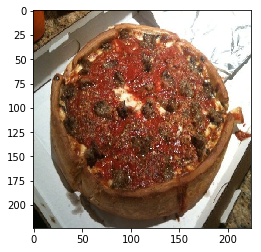

In [228]:
plt.imshow(test_image_pizza)

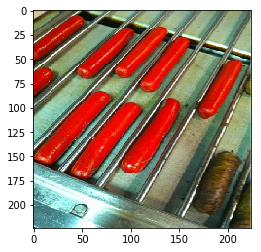

In [229]:
plt.imshow(test_image_hotdog)

In [230]:
def predict_class(model, image):
    y_pred = model.predict_classes([[image]])
    confidence = model.predict([[image]])
    print("Confidence:")
    print("{0:.2f}".format(confidence[0][y_pred][0]))
    
    print("Class:")
    if y_pred == 0:
        print("HOT DOG")
    else:
        print("PIZZA")

In [231]:
predict_class(model, test_image_pizza)

Confidence:
0.99
Class:
PIZZA


In [232]:
predict_class(model, test_image_hotdog)

Confidence:
0.78
Class:
HOT DOG
